In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
def read_csv(file, columns, timecolumn):
    """funkcija za čitanje podataka vremenske serije.
    Args:
        file(str): putanja do csv datoteke
        columns(list of str): značajke
        timecolumn(str): značajka vremena
    Returns:
         učitani dataframe
    """
    df = pd.read_csv(file,usecols=columns, parse_dates=[timecolumn], encoding='latin1')
    return df

Kreiranje dataframea koji sadrži sve mjesece 2023.

In [3]:
combined_df = pd.DataFrame()

for i in range(1,13):
        file = r"bojler_{}_{}.csv".format(i,2023)
        df = read_csv(file, columns=['time','total_active_power'], timecolumn='time')
        df=df.set_index('time')
        data_hourly = df['total_active_power'].resample('15T').mean()
        combined_df = pd.concat([combined_df, data_hourly], axis=0)
combined_df.rename(columns={combined_df.columns[0]:'total_active_power'},inplace=True)


C:\Users\matea\AppData\Local\Temp\ipykernel_17540\2522371466.py:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  combined_df = pd.concat([combined_df, data_hourly], axis=0)


In [4]:
def getSeason(month):
    """Vraca godisnje doba primljenog mjeseca
    Args:
        month(int): mjesec
    """
    #winter
    if month in [12,1,2]:
        return 0
    #spring
    elif month in [3,4,5]:
      return 1
    #summer
    elif month in [6,7,8]:
        return 2
    #autumn
    else:
        return 3

In [5]:
def getDay(day):
    """Vraca 0 za radni dan, 1 za neradni
    Args:
        day(int): dan
    """
    if day<5:
        #working day
        return 0
    else:
        #weekend
        return 1

Funkcije za istraživanje prosječnih vrijednosti 

In [6]:
def plotAverageWeekBySeason(df, seasons, column):
    """Grafički prikaz prosječnog tjedna po godišnjim dobima.
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
        seasons (list of int): lista godišnjih doba, 0-zima, 1-proljece, 2-ljeto, 3-zima
        column(str): gledana značajka
    """
    undersampled_df = df.resample('H').mean()
    undersampled_df['season'] = undersampled_df.index.month.map(getSeason)
    undersampled_df['dow'] = undersampled_df.index.dayofweek
    undersampled_df['hour'] = undersampled_df.index.hour
    undersampled_df=undersampled_df[undersampled_df['season'].isin(seasons)]
    grouped = undersampled_df.groupby(['dow', 'hour', 'season']).mean()
    pivoted_data = grouped.pivot_table(values=column, index=['dow', 'hour'], columns='season')
    plt.figure(figsize=(15,6))
    for season in pivoted_data.columns:
        label=f'{("ljeto" if season==2 else ("zima" if season==0 else ("jesen" if season==3 else "proljeće")))}'
        plt.plot(pivoted_data[season].values, label=label)
    plt.title(f'Prosječan {column} kroz tjedan', fontsize=18)
    plt.xlabel('vrijeme', fontsize=18)
    #plt.ylabel('snaga / w', fontsize=18)
    plt.legend(loc="upper right", fontsize=18)
    plt.xticks(ticks=range(0, 168, 24), labels=['pon', 'uto', 'sri', 'čet', 'pet', 'sub', 'ned'], rotation=45, fontsize=18)
    plt.tick_params(axis='y', labelsize=18)

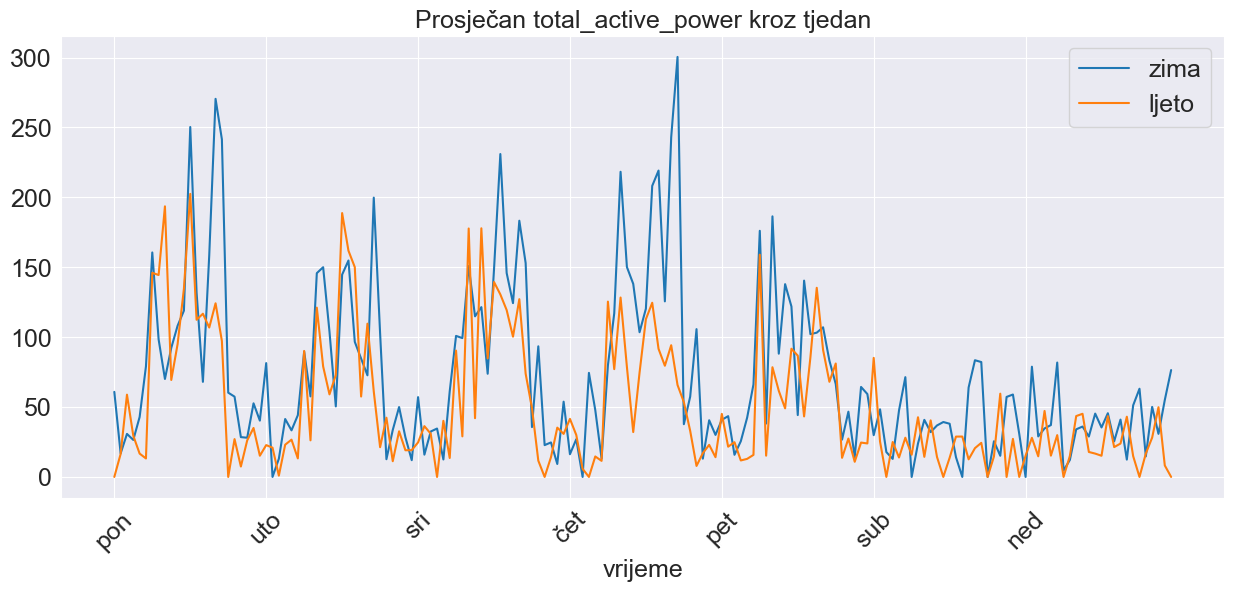

In [7]:
plotAverageWeekBySeason(combined_df,[0,2],'total_active_power')

In [32]:
def plotAverageWeekByMonth(df, months, column):
    """Grafički prikaz prosječnog tjedna po mjesecima.
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
        months (list of int): lista mjeseci,1-sijecanj, 12-prosinac
        column(str): gledana značajka
    """
    undersampled_df = df.resample('H').mean()
    undersampled_df['month'] = undersampled_df.index.month
    undersampled_df['dow'] = undersampled_df.index.dayofweek
    undersampled_df['hour'] = undersampled_df.index.hour
    undersampled_df=undersampled_df[undersampled_df['month'].isin(months)]
    grouped = undersampled_df.groupby(['dow', 'hour', 'month']).mean()
    pivoted_data = grouped.pivot_table(values=column, index=['dow', 'hour'], columns='month')
    plt.figure(figsize=(15,6))
    for month in pivoted_data.columns:
        label=f'{month}.mjesec'
        plt.plot(pivoted_data[month].values, label=label)
    plt.title(f'Prosječan {column} kroz tjedan',fontsize=18)
    plt.xlabel('vrijeme',fontsize=18)
    plt.legend(loc="upper right",fontsize=18)
    plt.xticks(ticks=range(0, 168, 24), labels=['pon', 'uto', 'sri', 'čet', 'pet', 'sub', 'ned'], rotation=45, labelsize=18)
    plt.tick_params(axis='y', labelsize = 18)
    #plt.ylabel('snaga / w', fontsize=18)


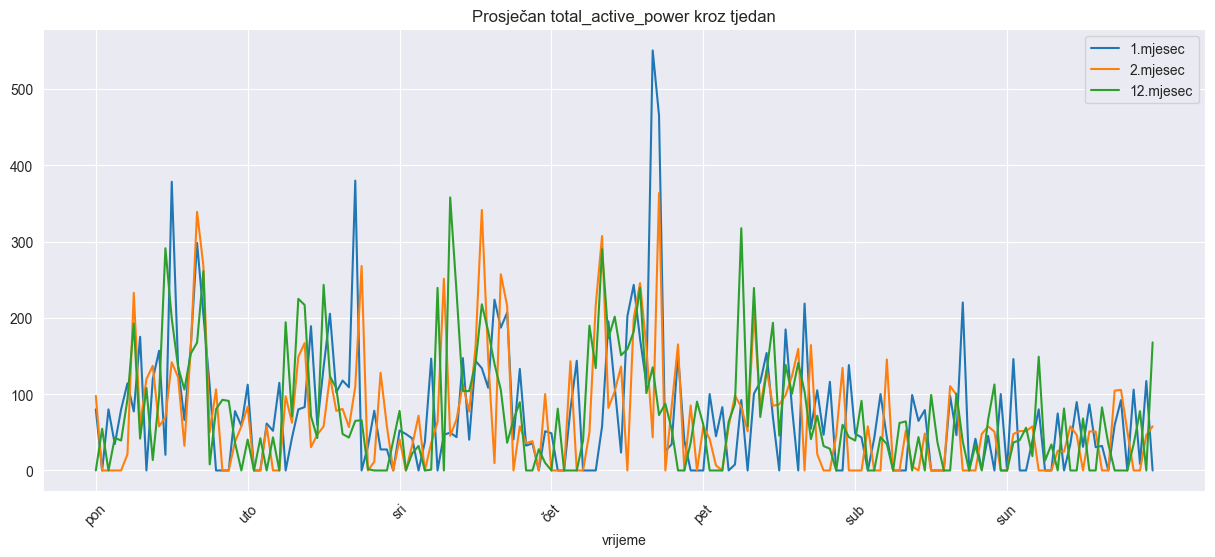

In [50]:
plotAverageWeekByMonth(combined_df,[1,2,12],'total_active_power')

In [47]:
def plotAverageWorkingAndWeekendDayBySeason(df,days, column, seasons=None ):   
    """Grafički prikaz prosječnog radnog i neradnog dana po godišnjim dobima ili čitav vremenski interval.
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
        days (list of int): lista dana, 0-radni, 1-vikend
        column(str): gledana značajka
        seasons (list of int): opcionalno, lista godišnjih doba, 0-zima, 1-proljece, 2-ljeto, 3-zima
    """
    if seasons!=None:
        undersampled_df = df.resample('H').mean()
        undersampled_df['dow'] = undersampled_df.index.dayofweek
        undersampled_df['hour'] = undersampled_df.index.hour
        undersampled_df['day'] = undersampled_df.index.dayofweek.map(getDay)
        undersampled_df['season'] = undersampled_df.index.month.map(getSeason)
        undersampled_df=undersampled_df[undersampled_df['season'].isin(seasons)]
        undersampled_df=undersampled_df[undersampled_df['day'].isin(days)]
    
        grouped = undersampled_df.groupby(['day', 'hour', 'season']).mean()
        pivoted_data = grouped.pivot_table(values=column, index=['hour'], columns=['day','season'])
        plt.figure(figsize=(15,6))
        for day in pivoted_data.columns.levels[0]:
            for season in pivoted_data.columns.levels[1]:
                label=f'{("radni dan" if day==0 else "vikend")}, {("ljeto" if season==2 else ("zima" if season==0 else ("jesen" if season==3 else "proljeće")))}'
                plt.plot(pivoted_data[day][season].values, label=label)
                
        plt.title(f'Prosječan {column} po satu kroz dan za različita godišnja doba', fontsize=18)
    else:
        undersampled_df = df.resample('H').mean()
        undersampled_df['dow'] = undersampled_df.index.dayofweek
        undersampled_df['hour'] = undersampled_df.index.hour
        undersampled_df['day'] = undersampled_df.index.dayofweek.map(getDay)
        
        grouped = undersampled_df.groupby(['day', 'hour']).mean()
        pivoted_data = grouped.pivot_table(values=column, index=['hour'], columns=['day'])
        plt.figure(figsize=(15,6))
        for day in pivoted_data.columns:
            plt.plot(pivoted_data[day].values, label=f'{"radni dan" if day==0 else "vikend"}')
        plt.title(f'Prosječan {column} po satu kroz dan',fontsize=18)
    plt.xlabel('vrijeme / h',fontsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.tick_params(axis='x', labelsize=18)
    plt.legend(loc="upper right",fontsize=16)
    #plt.ylabel('snaga / w', fontsize=18)


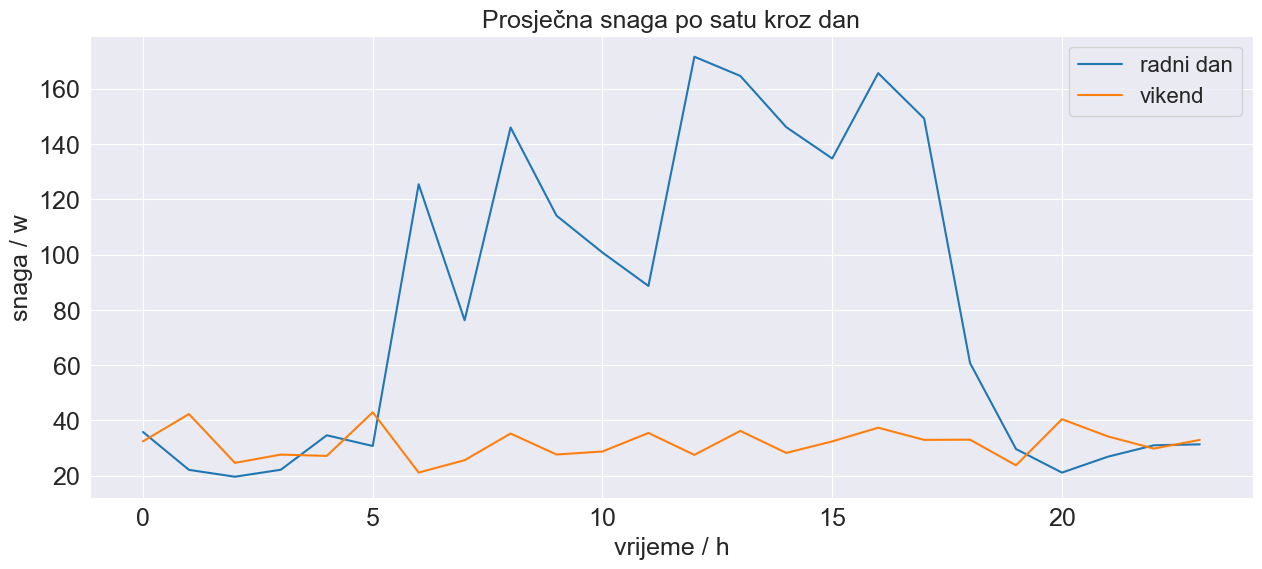

In [46]:
plotAverageWorkingAndWeekendDayBySeason(combined_df,[0,1],'total_active_power')

In [40]:
def plotAverageDayBySeason(df, column,  days=range(0,6), seasons=None):   
    """Grafički prikaz prosječnog radnog i neradnog dana po godišnjim dobima.
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
        column(str): gledana značajka
        days (list of int): lista dana, 0-ponedjeljak, 6-nedjelja
        seasons (list of int): opcionalno, lista godišnjih doba, 0-zima, 1-proljece, 2-ljeto, 3-zima
    """
    day_names = ['Ponedjeljak', 'Utorak', 'Srijeda', 'Četvrtak', 'Petak', 'Subota', 'Nedjelja']
    undersampled_df = df.resample('H').mean()
    undersampled_df['dow'] = undersampled_df.index.dayofweek
    undersampled_df['hour'] = undersampled_df.index.hour
    undersampled_df=undersampled_df[undersampled_df['dow'].isin(days)]

    if seasons!=None:
        undersampled_df['season'] = undersampled_df.index.month.map(getSeason)
        undersampled_df=undersampled_df[undersampled_df['season'].isin(seasons)]
        grouped = undersampled_df.groupby(['dow', 'hour', 'season']).mean()
        pivoted_data = grouped.pivot_table(values=column, index=['hour'], columns=['dow','season'])
        plt.figure(figsize=(15,6))
        for day in pivoted_data.columns.levels[0]:
            for season in pivoted_data.columns.levels[1]:
                label=f'{day_names[day]}, {("ljeto" if season==2 else ("zima" if season==0 else ("jesen" if season==3 else "proljeće")))}'
                plt.plot(pivoted_data[day][season].values, label=label)
        plt.title(f'Prosječan {column} po satu kroz dan za različita godišnja doba')
    else:
        grouped = undersampled_df.groupby(['dow', 'hour']).mean()
        pivoted_data = grouped.pivot_table(values=column, index=['hour'], columns='dow')
        plt.figure(figsize=(15,6))
        for day in pivoted_data.columns:
            label=f'{day_names[day]}'
            plt.plot(pivoted_data[day].values, label=label)
        plt.title(f'Prosječan {column} po satu kroz dan')
    plt.xlabel('vrijeme / h')
    plt.legend(loc="upper right")
    plt.xticks(rotation=45)

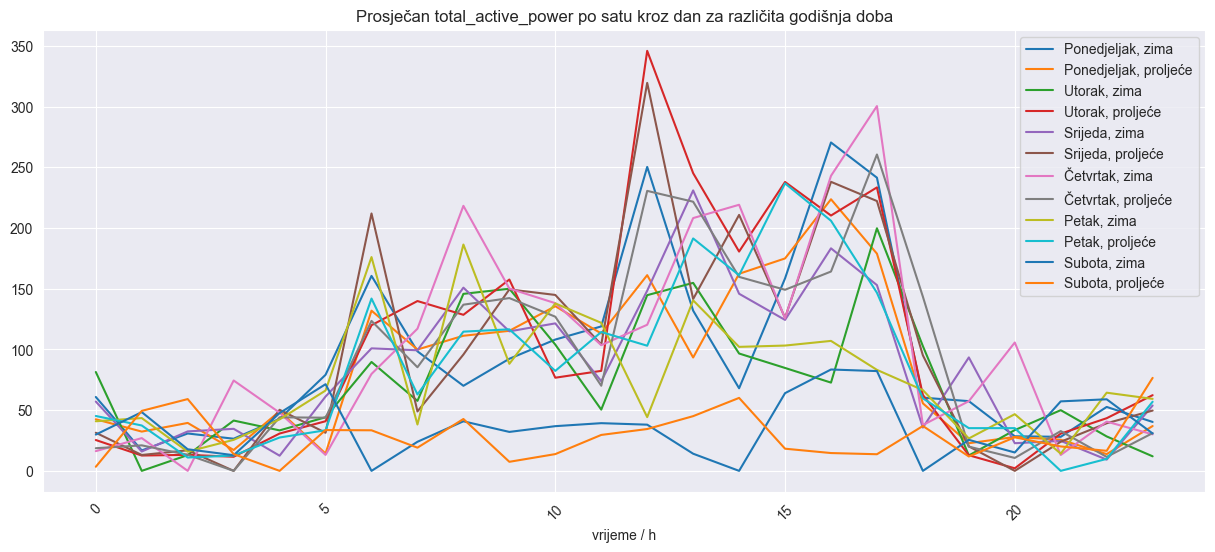

In [47]:
plotAverageDayBySeason(combined_df,'total_active_power',seasons=[0,1])

Graf autokorelacije snage

In [102]:
def autocorrelation(df, lags): 
    """Grafički prikaz autokorelacije. Iskazuje koliko je vrijednost na x=0 korelirana s vrijednosti udaljenoj za x vremenskih jedinica.
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
        lags (list of int): lista brojeva koji izražavaju udaljenost susjednih trenutaka za koje se računa korelacija
    """
    for lag in lags:
        plt.figure(figsize=(8,4))
        plot_acf(df, lags=lag)
        plt.xlabel('Vremenski odmak')
        plt.ylabel('Korelacija')
        plt.title('Autokorelacija')
        plt.show()

<Figure size 800x400 with 0 Axes>

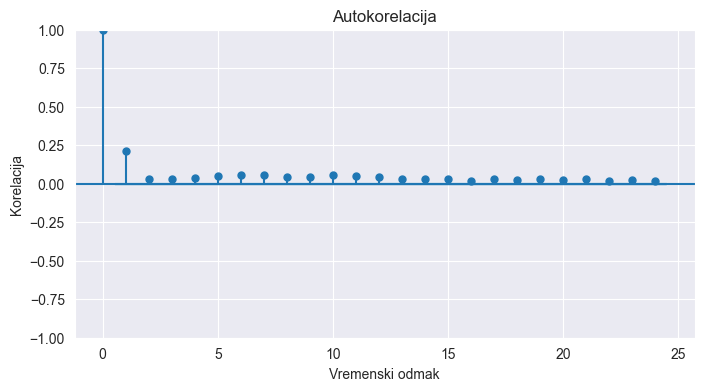

In [103]:
autocorrelation(combined_df,[24])

Adf test - provjera stacionarnosti

In [72]:
def adfTest(df):
    """Vraća vrijednosti adf testa i zaključak.
    Args:
        df (Pandas dataframe): dataframe s podacima
    """
    test_results = adfuller(df)
    print('ADF Statistika: ', test_results[0])
    print('P-Vrijednost: ', test_results[1])
    print('Kritične vrijednosti:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))
    if(test_results[0] < min(adf_stat for thres, adf_stat in test_results[4].items())):
        print("ADF statistika je manja od kritičnih vrijednosti. Podaci su vjerojatno stacionarni.")
    else:
        print("ADF statistika je veća od kritičnih vrijednosti. Podaci vjerojatno nisu stacionarni.")

In [73]:
adfTest(combined_df)

ADF Statistika:  -28.187992721917336
P-Vrijednost:  0.0
Kritične vrijednosti:
	1%: -3.43
	5%: -2.86
	10%: -2.57
ADF statistika je manja od kritičnih vrijednosti. Podaci su vjerojatno stacionarni.


In [91]:
def decomposeTimeSeries(df, column, period):
    """
    Grafički prikaz komponenti serije.
    Args:
        df (Pandas dataframe): dataframe s podacima i vremenskim indeksom
        column (str): značajka
        period (int): period za koji se traži sezonalna komponenta (broj redaka nakon kojih se očekuje sezonalnost)
    """
    result = seasonal_decompose(combined_df[column], period = period, model='additive')
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Dekompozicija krivulje {column}",fontsize=18)
    
    plt.subplot(411)
    plt.plot(combined_df[column], label='original')
    plt.legend(loc='upper right',fontsize=18)
    plt.tick_params(axis='y', labelsize=16)
    plt.tick_params(axis='x', labelsize=16)
    plt.subplot(412)
    plt.plot(result.trend, label='trend')
    plt.legend(loc='upper right',fontsize=18)
    plt.tick_params(axis='y', labelsize=16)
    plt.tick_params(axis='x', labelsize=16)
    plt.subplot(413)
    plt.plot(result.seasonal, label='sezonalna komponenta')
    plt.legend(loc='best',fontsize=18)
    plt.tick_params(axis='y', labelsize=16)
    plt.tick_params(axis='x', labelsize=16)
    plt.subplot(414)
    plt.plot(result.resid, label='greška')
    plt.legend(loc='upper right',fontsize=18)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.tick_params(axis='y', labelsize=16)
    plt.tick_params(axis='x', labelsize=16)
    fig = plt.gcf()
    fig.text(0.5, 0.00, 'vrijeme', ha='center', va='center', fontsize=18)
    #fig.text(0.02, 0.5, 'snaga / W', ha='center', va='center', rotation='vertical')  # Adjusted
    plt.tick_params(axis='y', labelsize=16)
    plt.tick_params(axis='x', labelsize=16)
    plt.show()

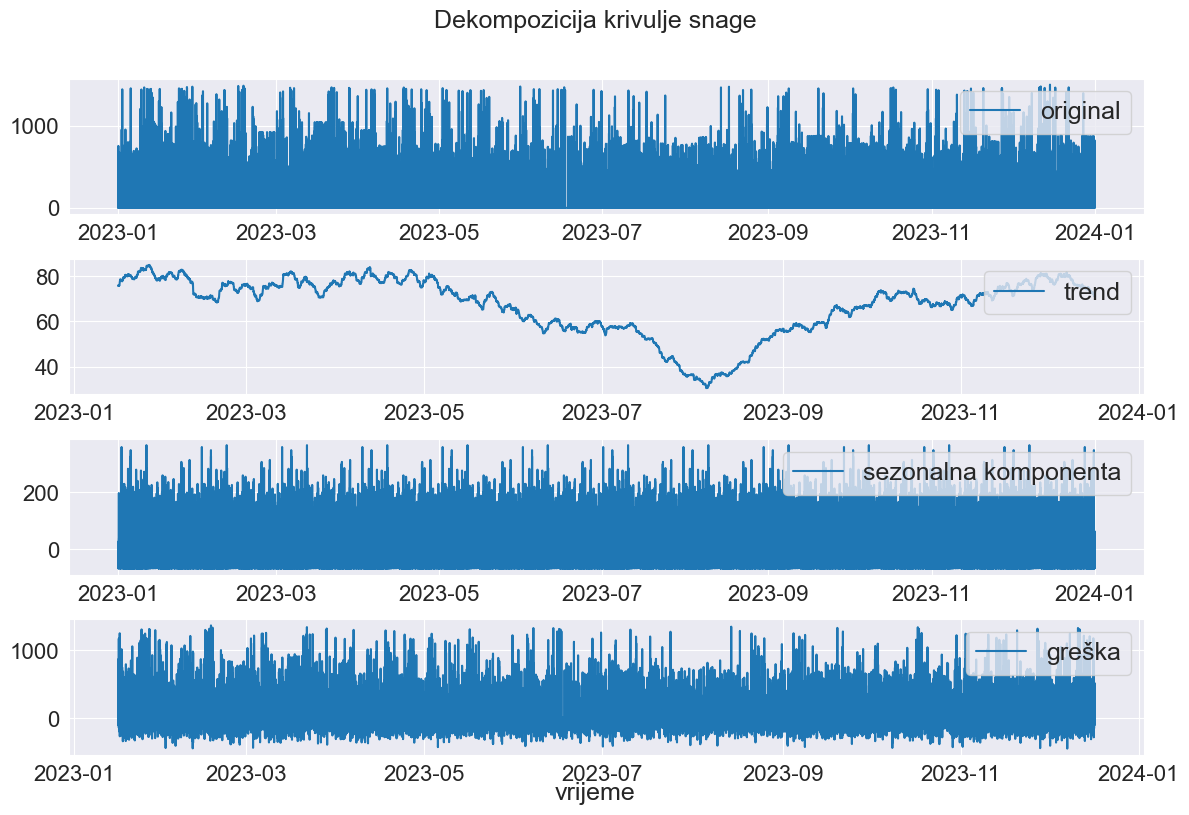

In [90]:
decomposeTimeSeries(combined_df,'total_active_power',24*4*30)

Korelacija medu različitim kolonama

In [82]:
corr = df.corr(method = 'pearson')
corr

,total_active_power
total_active_power,1.0


In [57]:
def movingAverage(df, column, windows):
    """Grafički prikaz pomičnog prosjeka za različite prozore.
    Args:
        df (Pandas dataframe): dataframe s podacima i vremenskim indeksom
        column (str): značajka
        windows (list of int): lista prozora, brojeva koji određuju koliko podataka ulazi u izračun prosjeka
    """
    plt.figure(figsize=(10, 5))
    plt.plot(combined_df[column], label='originalni podaci')
    for w in windows:
        average = df[column].rolling(window=w).mean()
        plt.plot(average,'.-', label=f'pomični prosjek - prozor {w} tjedana')
    plt.grid(linestyle=':')
    plt.xlabel('vrijeme',fontsize=18)
    #plt.ylabel('snaga / W',fontsize=18)
    plt.title(f'Pomičan prosjek',fontsize=18)
    plt.legend(fontsize=16)
    plt.tick_params(axis='y', labelsize=18)
    plt.tick_params(axis='x', labelsize=18)
    plt.show()

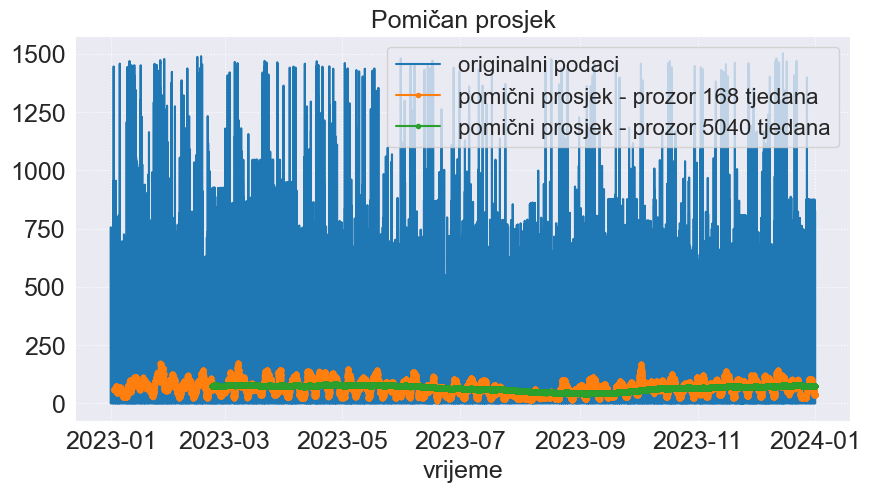

In [58]:
movingAverage(combined_df, 'total_active_power', [24*7,24*7*30])